In [1]:
import gc

from facenet_pytorch import MTCNN, InceptionResnetV1, fixed_image_standardization, training
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch.utils.tensorboard import SummaryWriter
from torch import optim
from torch.optim.lr_scheduler import MultiStepLR
from torchvision import datasets, transforms
import numpy as np

In [2]:
# Cuda maintenance
gc.collect()
torch.cuda.empty_cache()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Torch device: ", device)

Torch device:  cuda


# Implement image classifier for 5 classes

---

https://lms.skillfactory.ru/courses/course-v1:SkillFactory+MISISDS22p3s+SEPT22/courseware/c50cb25f34ee4c37ac16876299d21bb5/4a46cc1c667b44de8a6c01215879e481/1?activate_block_id=block-v1%3ASkillFactory%2BMISISDS22p3s%2BSEPT22%2Btype%40vertical%2Bblock%40698440eac17743859050bfdcf82a7286


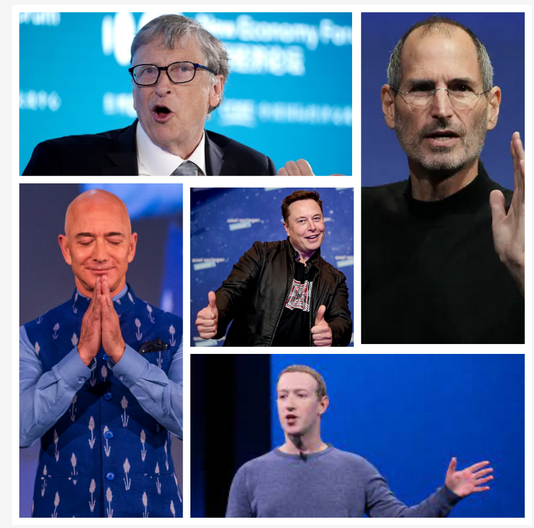


The task is to implement an image classifier using any pretrained model given test and validation databases.

## Load and visualize data

---


In [3]:
train_data_path = '/home/rpc/Desktop/FaceRecognition/data/train'
test_data_path = '/home/rpc/Desktop/FaceRecognition/data/valid'

In [4]:
# Dataset paramaters

BATCH_SIZE = 32
WORKERS = 8
IMG_SIZE = 160

In [5]:
train_dataset = datasets.ImageFolder(train_data_path, transform=transforms.Resize((IMG_SIZE, IMG_SIZE)))
visu_train_loader = DataLoader(
    train_dataset,
    num_workers=WORKERS,
    batch_size=BATCH_SIZE,
    collate_fn=training.collate_pil,
    shuffle=True 
)

In [6]:
idx_to_class = dict()

for key, value in train_dataset.class_to_idx.items():
    idx_to_class[value] = key

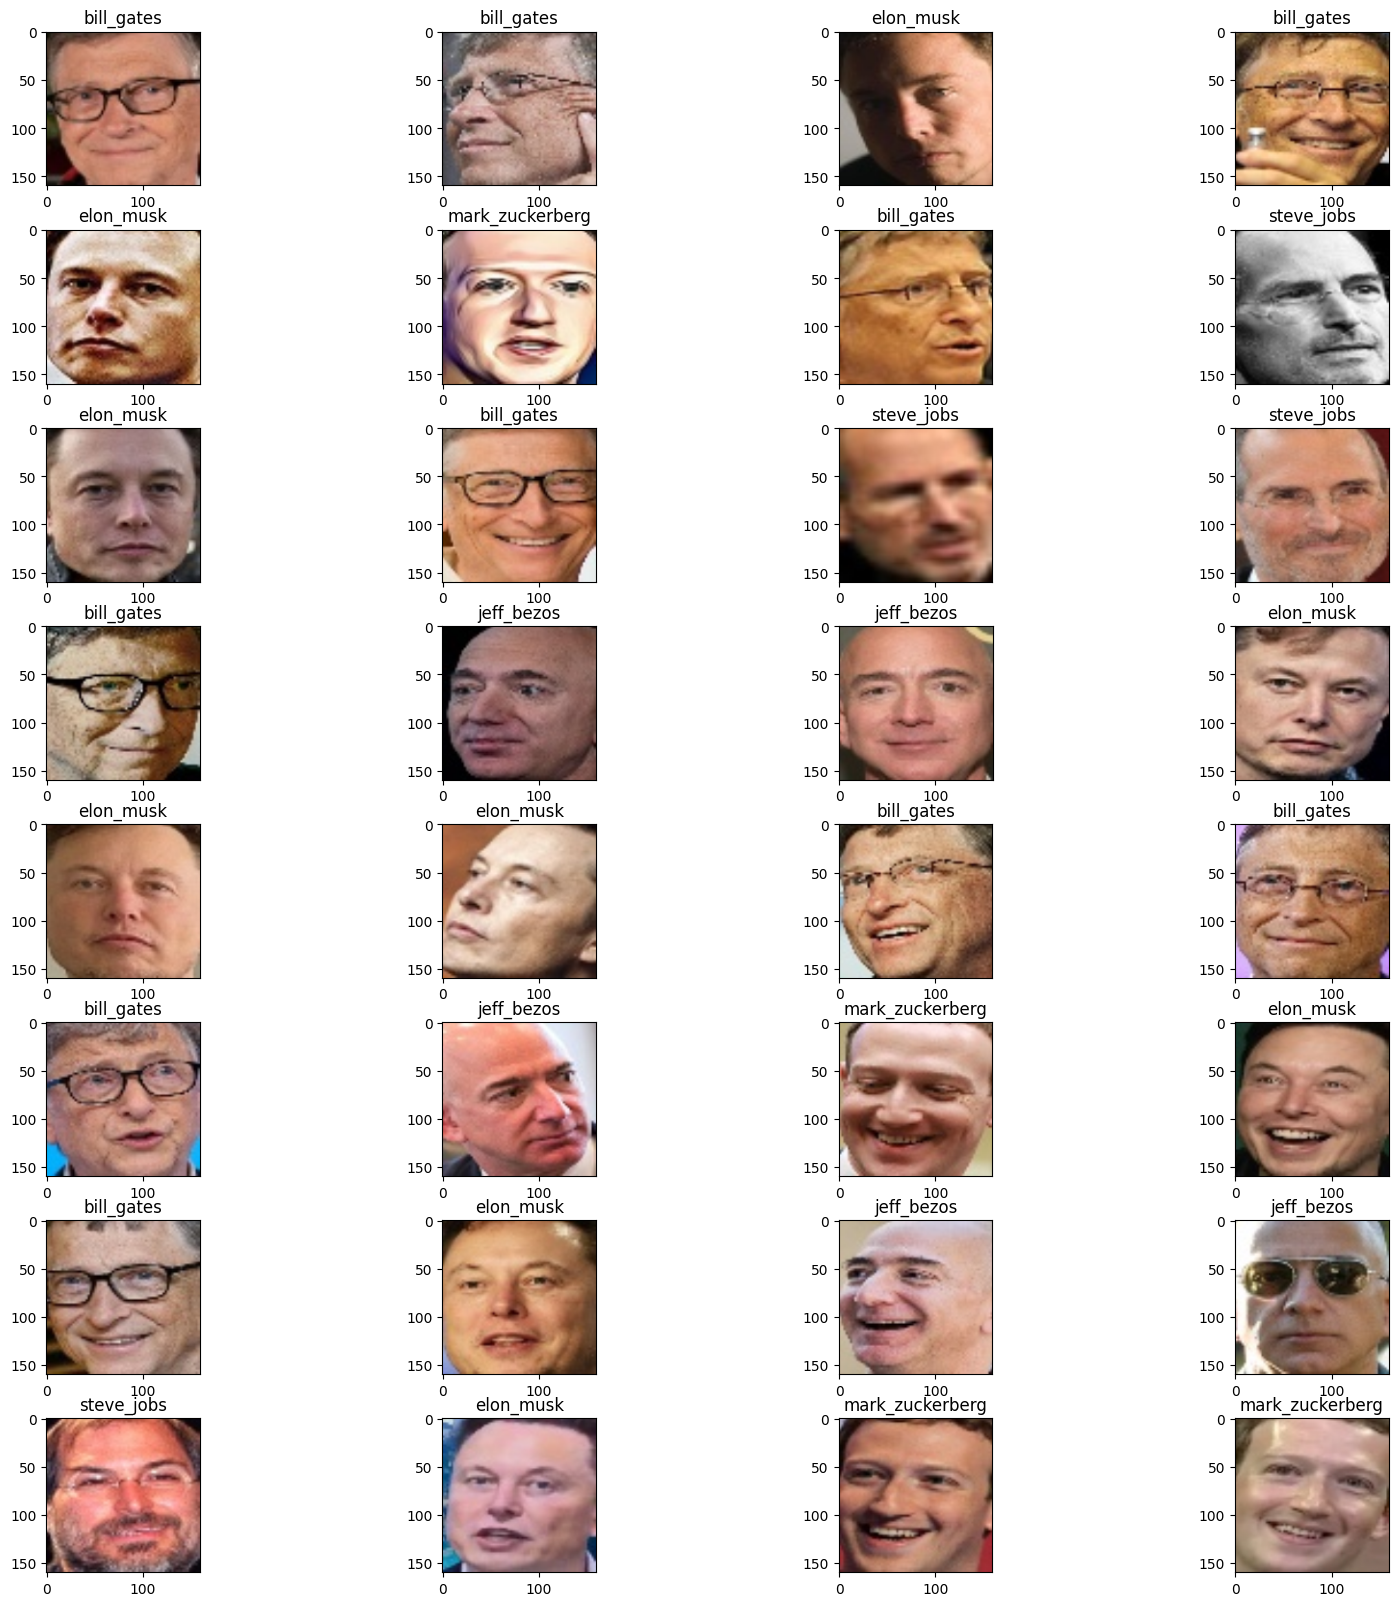

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline 

ncols=4
nrows=int(BATCH_SIZE/ncols)

images, labels = next(iter(visu_train_loader))

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 16))
fig.tight_layout()

for i in range(nrows):
    for j in range(ncols):
        idx = i*ncols + j
        if idx >= len(images):
            break
        ax[i][j].imshow(images[idx])
        ax[i][j].set_title(idx_to_class[labels[idx]])
    
plt.show()

## Finetune pretrained model

---

``InceptionResnetV1`` pretrained model from ``facenet-pytorch`` module (https://github.com/timesler/facenet-pytorch)
was chosen. It was trained on ``VGGFace2`` dataset (https://github.com/cydonia999/VGGFace2-pytorch).


In [ ]:
help(InceptionResnetV1)

In [8]:
resnet_model = InceptionResnetV1(classify=True,
    pretrained='vggface2',
    num_classes=len(train_dataset.class_to_idx)).to(device)

In [9]:
optimizer = optim.Adam(resnet_model.parameters(), lr=0.001)
scheduler = MultiStepLR(optimizer, [5, 10])

transformations = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    np.float32,
    transforms.ToTensor(),
    fixed_image_standardization
])

train_dataset = datasets.ImageFolder(train_data_path, transform=transformations)

In [10]:
from sklearn.model_selection import train_test_split

train_idx, validation_idx = train_test_split(list(range(len(train_dataset))),
                                             test_size=0.3, random_state=42, shuffle=True)


In [11]:
train_loader = DataLoader(
    train_dataset,
    num_workers=WORKERS,
    batch_size=BATCH_SIZE,
    sampler=SubsetRandomSampler(train_idx)
)

val_loader = DataLoader(
    train_dataset,
    num_workers=WORKERS,
    batch_size=BATCH_SIZE,
    sampler=SubsetRandomSampler(validation_idx)
)

In [ ]:
images, labels = next(iter(train_loader))

In [ ]:
images, labels = next(iter(test_loader))

In [ ]:
images

In [ ]:
train_dataset = datasets.ImageFolder(train_data_path, transform=transforms.Resize((IMG_SIZE, IMG_SIZE)))
train_dataset.samples = [
    (p, p.replace(train_data_path, train_data_path + '_cropped'))
        for p, _ in train_dataset.samples
]
        
train_loader = DataLoader(
    train_dataset,
    num_workers=workers,
    batch_size=batch_size,
    collate_fn=training.collate_pil
)

for i, (x, y) in enumerate(train_loader):
    mtcnn(x, save_path=y)
    print('\rBatch {} of {}'.format(i + 1, len(train_loader)), end='')
    
# Remove mtcnn to reduce GPU memory usage
del mtcnn



In [ ]:
mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device
)

In [ ]:
### For test



test_dataset = datasets.ImageFolder(test_data_path, transform=transforms.Resize((512, 512)))
test_dataset.samples = [
    (p, p.replace(test_data_path, test_data_path + '_cropped'))
        for p, _ in test_dataset.samples
]
        
test_loader = DataLoader(
    test_dataset,
    num_workers=WORKERS,
    batch_size=BATCH_SIZE,
    collate_fn=training.collate_pil
)

for i, (x, y) in enumerate(test_loader):
    mtcnn(x, save_path=y)
    print('\rBatch {} of {}'.format(i + 1, len(test_loader)), end='')
    
# Remove mtcnn to reduce GPU memory usage
del mtcnn

In [ ]:
resnet = InceptionResnetV1(
    classify=True,
    pretrained='vggface2',
    num_classes=len(train_dataset.class_to_idx)
).to(device)

In [ ]:
len(train_dataset.class_to_idx)

In [ ]:
optimizer = optim.Adam(resnet.parameters(), lr=0.001)
scheduler = MultiStepLR(optimizer, [5, 10])

trans = transforms.Compose([
    np.float32,
    transforms.ToTensor(),
    fixed_image_standardization
])
train_dataset = datasets.ImageFolder(train_data_path + '_cropped', transform=trans)
img_inds = np.arange(len(train_dataset))
np.random.shuffle(img_inds)
train_inds = img_inds[:int(0.8 * len(img_inds))]
val_inds = img_inds[int(0.8 * len(img_inds)):]

train_loader = DataLoader(
    train_dataset,
    num_workers=workers,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(train_inds)
)
val_loader = DataLoader(
    train_dataset,
    num_workers=workers,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(val_inds)
)

In [12]:
loss_fn = torch.nn.CrossEntropyLoss()
metrics = {
    'fps': training.BatchTimer(),
    'acc': training.accuracy
}

In [15]:
writer = SummaryWriter()
writer.iteration, writer.interval = 0, 10

EPOCHS = 8


print('\n\nInitial')
print('-' * 10)
resnet_model.eval()
training.pass_epoch(
    resnet_model, loss_fn, val_loader,
    batch_metrics=metrics, show_running=True, device=device,
    writer=writer
)

for epoch in range(EPOCHS):
    print('\nEpoch {}/{}'.format(epoch + 1, EPOCHS))
    print('-' * 10)

    resnet_model.train()
    training.pass_epoch(
        resnet_model, loss_fn, train_loader, optimizer, scheduler,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )

    resnet_model.eval()
    training.pass_epoch(
        resnet_model, loss_fn, val_loader,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )

writer.close()



Initial
----------
Valid |    29/29   | loss:    1.6534 | fps: 1486.3495 | acc:    0.1476   

Epoch 1/8
----------
Train |    66/66   | loss:    0.3566 | fps:  386.7076 | acc:    0.8856   
Valid |    29/29   | loss:    0.1466 | fps: 1483.1847 | acc:    0.9601   

Epoch 2/8
----------
Train |    66/66   | loss:    0.1219 | fps:  384.9684 | acc:    0.9598   
Valid |    29/29   | loss:    0.3756 | fps: 1493.0704 | acc:    0.9149   

Epoch 3/8
----------
Train |    66/66   | loss:    0.1363 | fps:  409.1975 | acc:    0.9614   
Valid |    29/29   | loss:    0.1449 | fps: 1461.1799 | acc:    0.9644   

Epoch 4/8
----------
Train |    66/66   | loss:    0.0530 | fps:  384.0443 | acc:    0.9836   
Valid |    29/29   | loss:    0.1142 | fps: 1496.5796 | acc:    0.9644   

Epoch 5/8
----------
Train |    66/66   | loss:    0.0470 | fps:  385.5900 | acc:    0.9848   
Valid |    29/29   | loss:    0.1283 | fps: 1498.6233 | acc:    0.9709   

Epoch 6/8
----------
Train |    66/66   | loss:    0.0

In [16]:
test_dataset = datasets.ImageFolder(test_data_path, transform=transformations)

test_loader = DataLoader(
    test_dataset,
    num_workers=WORKERS,
    batch_size=BATCH_SIZE
)

In [18]:
resnet_model.eval()

y_true = []
y_predicted = []

for batch_idx, (x, y) in enumerate(test_loader):
    scores = resnet_model(x.cuda())
    softmax = torch.exp(scores).cpu()
    prob = list(softmax.detach().numpy())
    predictions = np.argmax(prob, axis=1)
    y_true.append(y.data)
    y_predicted.append(predictions)

In [ ]:
type(y_true)

In [19]:
y_true = [item for sublist in y_true for item in sublist]

In [20]:
y_predicted = [item for sublist in y_predicted for item in sublist]

In [21]:
from sklearn import metrics 

In [22]:
confusion_matrix = metrics.confusion_matrix(y_true, y_predicted)

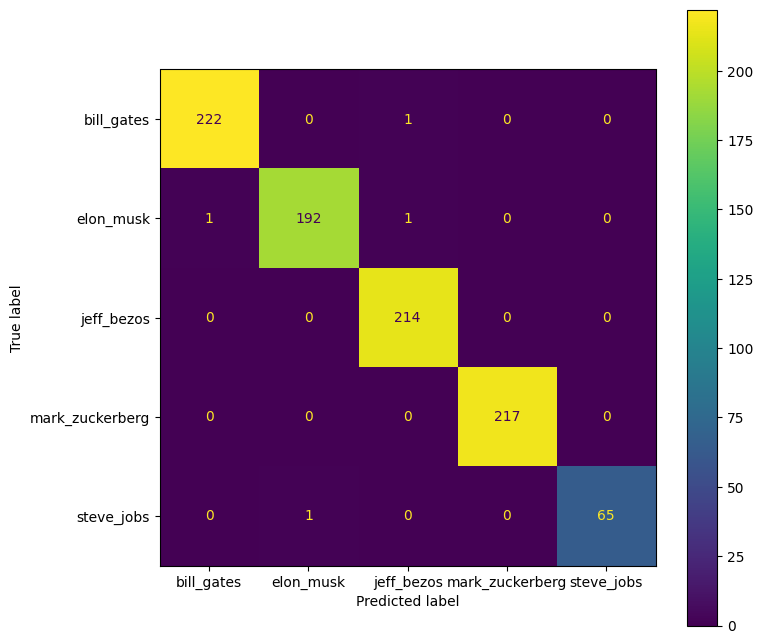

In [23]:
import matplotlib.pyplot as plt

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix,
                                            display_labels = list(train_dataset.class_to_idx.keys()))

fig, ax = plt.subplots(figsize=(8,8))

cm_display.plot(ax=ax)
plt.show()

In [ ]:
type(cm_display)